In [1]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("England CSV.csv")
df.head()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Fouls,A Fouls,H Corners,A Corners,H Yellow,A Yellow,H Red,A Red,Display_Order,League
0,16/01/2025,2024/25,Ipswich Town,Brighton & Hove Albion,0,2,A,0.0,1.0,A,...,13.0,14.0,1.0,9.0,2.0,2.0,0.0,0.0,20250116,Premier League
1,16/01/2025,2024/25,Man United,Southampton,3,1,H,0.0,1.0,A,...,7.0,10.0,4.0,4.0,1.0,3.0,0.0,0.0,20250116,Premier League
2,15/01/2025,2024/25,Everton,Aston Villa,0,1,A,0.0,0.0,D,...,17.0,10.0,8.0,5.0,2.0,1.0,0.0,0.0,20250115,Premier League
3,15/01/2025,2024/25,Leicester,Crystal Palace,0,2,A,0.0,0.0,D,...,7.0,6.0,4.0,3.0,0.0,0.0,0.0,0.0,20250115,Premier League
4,15/01/2025,2024/25,Newcastle,Wolves,3,0,H,1.0,0.0,H,...,10.0,13.0,4.0,2.0,0.0,2.0,0.0,0.0,20250115,Premier League


In [3]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [4]:
df.dropna(inplace=True)

In [5]:
# Check for impossible values (e.g., negative goals)
print(df[['FTH Goals', 'FTA Goals']].describe())

         FTH Goals    FTA Goals
count  9329.000000  9329.000000
mean      1.536178     1.179333
std       1.305748     1.157003
min       0.000000     0.000000
25%       1.000000     0.000000
50%       1.000000     1.000000
75%       2.000000     2.000000
max       9.000000     9.000000


In [6]:
# Clip extreme shots/corners (if needed)
df['HS'] = df['H Shots'].clip(upper=df['H Shots'].quantile(0.99))

In [7]:
# Feature engineering (better than outlier removal)
df['Home_GoalDiff'] = df['FTH Goals'] - df['FTA Goals']

In [8]:
# Keep key stats and engineer ratios:
df['Shot_Ratio'] = df['H Shots'] / (df['A Shots'] + 1e-6)  # Avoid division by zero
df['Corner_Ratio'] = df['H Corners'] / (df['A Corners'] + 1e-6)

In [9]:
# First, let's properly preprocess the date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

In [10]:
columns_to_drop = ['Date','Season', 'Referee', 'HS', 'H SOT', 'A SOT', 'H Shots', 'A Shots', 'H Fouls', 'A Fouls', 'H Corners', 
                   'A Corners', 'A Yellow', 'H Yellow', 'H Red', 'A Red', 'League', 'Display_Order']
df_reduced = df.drop(columns=columns_to_drop)

In [11]:
df_reduced 

,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,Home_GoalDiff,Shot_Ratio,Corner_Ratio,Year,Month,Day,DayOfWeek
0,Ipswich Town,Brighton & Hove Albion,0,2,A,0.0,1.0,A,-2,0.454545,0.111111,2025,1,16,3
1,Man United,Southampton,3,1,H,0.0,1.0,A,2,1.769231,1.000000,2025,1,16,3
2,Everton,Aston Villa,0,1,A,0.0,0.0,D,-1,0.909091,1.600000,2025,1,15,2
3,Leicester,Crystal Palace,0,2,A,0.0,0.0,D,-2,2.333333,1.333333,2025,1,15,2
4,Newcastle,Wolves,3,0,H,1.0,0.0,H,3,1.307692,1.999999,2025,1,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,Leicester,Aston Villa,0,0,D,0.0,0.0,D,0,1.000000,1.250000,2000,8,19,5
9325,Leeds,Everton,2,0,H,2.0,0.0,H,2,1.416667,1.500000,2000,8,19,5
9326,Derby,Southampton,2,2,D,1.0,2.0,A,0,0.461538,0.625000,2000,8,19,5
9327,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,-2,0.375000,2.000000,2000,8,19,5


In [12]:
# First, let's check for any remaining categorical columns
print("Data types before encoding:\n", df_reduced.dtypes)

# Identify any remaining categorical columns that need encoding
categorical_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

Data types before encoding:
 HomeTeam          object
AwayTeam          object
FTH Goals          int64
FTA Goals          int64
FT Result         object
HTH Goals        float64
HTA Goals        float64
HT Result         object
Home_GoalDiff      int64
Shot_Ratio       float64
Corner_Ratio     float64
Year               int32
Month              int32
Day                int32
DayOfWeek          int32
dtype: object
Categorical columns to encode: ['HomeTeam', 'AwayTeam', 'FT Result', 'HT Result']


In [25]:
# First, ensure all categorical columns are properly encoded
categorical_cols = ['HomeTeam', 'AwayTeam']

# Use LabelEncoder for team names
label_encoder = LabelEncoder()

# Create a combined list of all team names to ensure consistent encoding
all_teams = pd.concat([df_reduced['HomeTeam'], df_reduced['AwayTeam']]).unique()
label_encoder.fit(all_teams)

# Apply encoding to both home and away teams
df_reduced['HomeTeam'] = label_encoder.transform(df_reduced['HomeTeam'])
df_reduced['AwayTeam'] = label_encoder.transform(df_reduced['AwayTeam'])

In [27]:
if 'FT Result' in df_reduced.columns:
    df_reduced['FT Result'] = df_reduced['FT Result'].map({'H': 0, 'D': 1, 'A': 2})

In [29]:
if 'HT Result' in df_reduced.columns:
    df_reduced['HT Result'] = df_reduced['HT Result'].map({'H': 0, 'D': 1, 'A': 2})

In [31]:
# First, let's check for any remaining categorical columns
print("Data types before encoding:\n", df_reduced.dtypes)

# Identify any remaining categorical columns that need encoding
categorical_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

Data types before encoding:
 HomeTeam           int32
AwayTeam           int32
FTH Goals          int64
FTA Goals          int64
FT Result          int64
HTH Goals        float64
HTA Goals        float64
HT Result          int64
Home_GoalDiff      int64
Shot_Ratio       float64
Corner_Ratio     float64
Year               int32
Month              int32
Day                int32
DayOfWeek          int32
dtype: object
Categorical columns to encode: []


In [33]:
# Create classification target (win/lose/draw)
df_reduced['Result'] = df_reduced['Home_GoalDiff'].apply(lambda x: 'Win' if x > 0 else ('Draw' if x == 0 else 'Lose'))

In [35]:
# Split features and target
X = df_reduced.drop(columns=['FTH Goals', 'FTA Goals', 'Home_GoalDiff', 'Result'])
y = df_reduced['Result']

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Verify all columns are numeric
print("\nFeature types after encoding:\n", X.dtypes)


Feature types after encoding:
 HomeTeam          int32
AwayTeam          int32
FT Result         int64
HTH Goals       float64
HTA Goals       float64
HT Result         int64
Shot_Ratio      float64
Corner_Ratio    float64
Year              int32
Month             int32
Day               int32
DayOfWeek         int32
dtype: object


In [41]:
# Initialize and train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [45]:
# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        Draw       1.00      1.00      1.00       455
        Lose       1.00      1.00      1.00       571
         Win       1.00      1.00      1.00       840

    accuracy                           1.00      1866
   macro avg       1.00      1.00      1.00      1866
weighted avg       1.00      1.00      1.00      1866



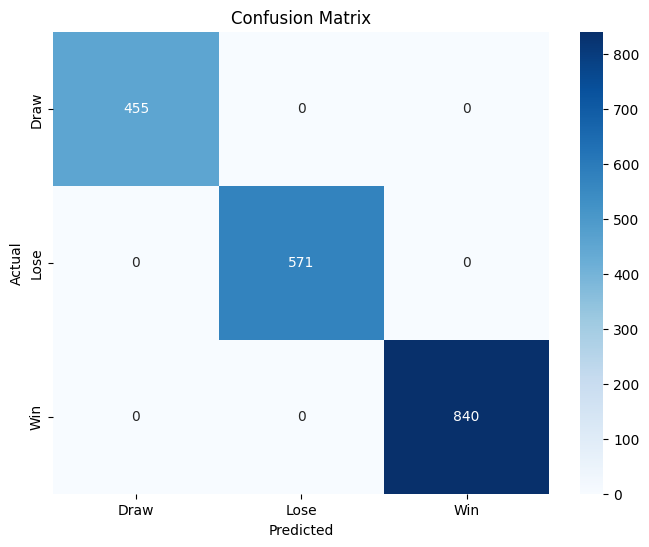

In [56]:
# Confusion Matrix
import seaborn as sns

from sklearn.metrics import (accuracy_score, 
                           classification_report, 
                           confusion_matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Draw', 'Lose', 'Win'], 
            yticklabels=['Draw', 'Lose', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

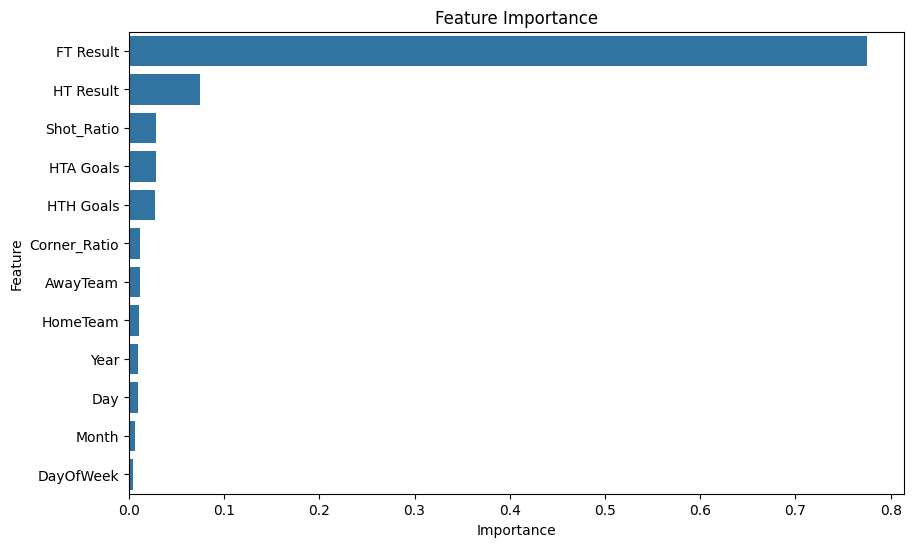

In [58]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()